# Cross-Validation with Sample Grouping

In this notebook, we explore the concept of **sample groups** in cross-validation and why they are crucial for obtaining reliable model performance estimates. We'll use the handwritten digits dataset to demonstrate some surprising results that highlight the importance of proper data splitting strategies.

## Learning Objectives
By the end of this notebook, you will understand:
- What sample grouping means in the context of cross-validation
- How data leakage can occur when groups are not properly handled
- The difference between optimistic and realistic performance estimates
- When and how to use group-aware cross-validation techniques
- Real-world scenarios where grouping is essential

## What is Sample Grouping?
Sample grouping refers to the situation where certain samples in your dataset are related or dependent on each other. These relationships can arise from:
- **Temporal dependencies**: Data collected over time from the same source
- **Individual subjects**: Multiple measurements from the same person/entity
- **Hierarchical structures**: Data from the same institution, location, or category
- **Data collection methodology**: Samples processed in the same batch or session

**Why does this matter?** If related samples end up in both training and test sets, your model might learn to recognize the underlying patterns of specific groups rather than generalizing to new, unseen groups. This leads to overly optimistic performance estimates that don't reflect real-world performance.

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
data, target = digits.data, digits.target

## The Dataset: Handwritten Digits
Let's start by loading the handwritten digits dataset. This dataset will serve as a perfect example to demonstrate the importance of grouping because it contains a hidden structure that we'll uncover.

We create a model consisting of a logistic regression classifier with a
preprocessor to scale the data.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Here we use a <tt class="docutils literal">MinMaxScaler</tt> as we know that each pixel's gray-scale is
strictly bounded between 0 (white) and 16 (black). This makes <tt class="docutils literal">MinMaxScaler</tt>
more suited in this case than <tt class="docutils literal">StandardScaler</tt>, as some pixels consistently
have low variance (pixels at the borders might almost always be zero if most
digits are centered in the image). Then, using <tt class="docutils literal">StandardScaler</tt> can result in
a very high scaled value due to division by a small number.</p>
</div>

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1_000))

The idea is to compare the estimated generalization performance using
different cross-validation techniques and see how such estimations are
impacted by underlying data structures. We first use a `KFold`
cross-validation without shuffling the data.

## Experiment 1: Standard K-Fold Cross-Validation

Now we'll compare different cross-validation strategies to see how they affect our performance estimates. This comparison will reveal the hidden dangers of ignoring data structure.

### Without Shuffling
First, let's establish a baseline using standard K-Fold cross-validation without shuffling the data. This means we'll use the data in its original order.

In [3]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(shuffle=False)
test_score_no_shuffling = cross_val_score(model, data, target, cv=cv, n_jobs=2)
print(
    "The average accuracy is "
    f"{test_score_no_shuffling.mean():.3f} ± "
    f"{test_score_no_shuffling.std():.3f}"
)

The average accuracy is 0.931 ± 0.027


Now, let's repeat the experiment by shuffling the data within the
cross-validation.

### With Shuffling
Next, let's see what happens when we shuffle the data before splitting. This is a common practice that randomly redistributes samples across folds.

In [4]:
cv = KFold(shuffle=True)
test_score_with_shuffling = cross_val_score(
    model, data, target, cv=cv, n_jobs=2
)
print(
    "The average accuracy is "
    f"{test_score_with_shuffling.mean():.3f} ± "
    f"{test_score_with_shuffling.std():.3f}"
)

The average accuracy is 0.968 ± 0.013


We observe that shuffling the data improves the mean accuracy. We can go a
little further and plot the distribution of the testing score. For such
purpose we concatenate the test scores.

## Analyzing the Results

**🚨 Important Observation**: The shuffled data gives us better performance! This should make us suspicious. In most real-world scenarios, simply shuffling shouldn't dramatically improve model performance - this suggests there's an underlying structure in our data that shuffling is artificially exploiting.

In [5]:
import pandas as pd

all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling],
    index=["KFold without shuffling", "KFold with shuffling"],
).T

Let's now plot the score distributions.

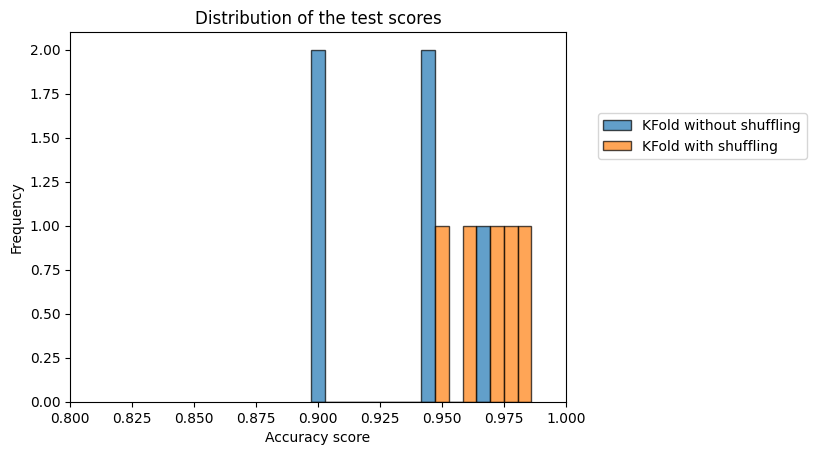

In [6]:
import matplotlib.pyplot as plt

all_scores.plot.hist(bins=16, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

Shuffling the data results in a higher cross-validated test accuracy with less
variance compared to when the data is not shuffled. It means that some
specific fold leads to a low score in this case.

In [7]:
print(test_score_no_shuffling)

[0.94166667 0.89722222 0.94707521 0.96657382 0.90250696]


Thus, shuffling the data breaks the underlying structure and thus makes the
classification task easier to our model. To get a better understanding, we can
read the dataset description in more detail:

## Understanding Data Leakage

**What just happened?** We've encountered a classic case of **data leakage** - a situation where information from the test set inadvertently influences the model during training.

### The Hidden Structure
When we shuffle the data, we're breaking apart natural groupings. If samples from the same group (in this case, the same writer) appear in both training and test sets, our model learns to recognize writer-specific patterns rather than general digit recognition patterns. This leads to:

1. **Overly optimistic performance estimates**: The model appears to perform better than it actually would on truly new data
2. **Poor generalization**: The model fails when encountering digits from completely new writers
3. **Misleading conclusions**: We might think our model is production-ready when it's not

This is why understanding and respecting the natural structure of your data is crucial for honest model evaluation.

In [8]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

If we read carefully, `load_digits` loads a copy of the **test set** of the
UCI ML hand-written digits dataset, which consists of 1797 images by
**13 different writers**. Thus, each writer wrote several times the same
numbers. Let's suppose the dataset is ordered by writer. Subsequently,
not shuffling the data will keep all writer samples together either in the
training or the testing sets. Mixing the data will break this structure, and
therefore digits written by the same writer will be available in both the
training and testing sets.

Besides, a writer will usually tend to write digits in the same manner. Thus,
our model will learn to identify a writer's pattern for each digit instead of
recognizing the digit itself.

We can solve this problem by ensuring that the data associated with a writer
should either belong to the training or the testing set. Thus, we want to
group samples for each writer.

Indeed, we can recover the groups by looking at the target variable.

In [9]:
target[:200]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4,
       6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5,
       4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3,
       5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6,
       4, 9])


It might not be obvious at first, but there is a structure in the target:
there is a repetitive pattern that always starts by some series of ordered
digits from 0 to 9 followed by random digits at a certain point. If we look in
detail, we see that there are 14 such patterns, always with around 130 samples
each.

Even if it is not exactly corresponding to the 13 writers in the documentation
(maybe one writer wrote two series of digits), we can make the hypothesis that
each of these patterns corresponds to a different writer and thus a different
group.

## Discovering the Group Structure

Let's investigate the structure hidden in our target variable. Understanding this structure is key to implementing proper cross-validation.

In [10]:
from itertools import count
import numpy as np

# defines the lower and upper bounds of sample indices
# for each writer
writer_boundaries = [
    0,
    130,
    256,
    386,
    516,
    646,
    776,
    915,
    1029,
    1157,
    1287,
    1415,
    1545,
    1667,
    1797,
]
groups = np.zeros_like(target)
lower_bounds = writer_boundaries[:-1]
upper_bounds = writer_boundaries[1:]

for group_id, lb, up in zip(count(), lower_bounds, upper_bounds):
    groups[lb:up] = group_id

We can check the grouping by plotting the indices linked to writers' ids.

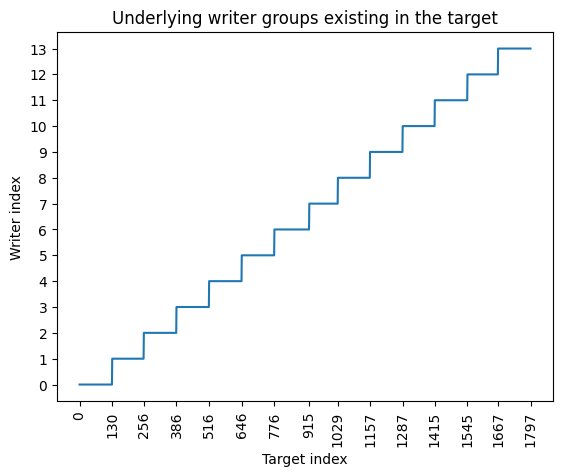

In [11]:
plt.plot(groups)
plt.yticks(np.unique(groups))
plt.xticks(writer_boundaries, rotation=90)
plt.xlabel("Target index")
plt.ylabel("Writer index")
_ = plt.title("Underlying writer groups existing in the target")

Once we group the digits by writer, we can incorporate this information into
the cross-validation process by using group-aware variations of the strategies
we have explored in this course, for example, the `GroupKFold` strategy.

## Experiment 2: Group-Aware Cross-Validation

Now we'll implement the proper solution: **Group-Aware Cross-Validation**. This ensures that all samples from the same writer are kept together in either the training or testing set, but never split between them.

In [12]:
from sklearn.model_selection import GroupKFold

cv = GroupKFold()
test_score = cross_val_score(
    model, data, target, groups=groups, cv=cv, n_jobs=2
)
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)

The average accuracy is 0.921 ± 0.021


We see that this strategy leads to a lower generalization performance than the
other two techniques. However, this is the most reliable estimate if our goal
is to evaluate the capabilities of the model to generalize to new unseen
writers. In this sense, shuffling the dataset (or alternatively using the
writers' ids as a new feature) would lead the model to memorize the different
writer's particular handwriting.

## Interpreting the Results

**The Reality Check**: Notice that GroupKFold gives us the lowest performance estimate. This might seem disappointing, but it's actually the most **honest and reliable** estimate of how our model will perform in the real world.

### Why the Lower Score is Actually Better
- **Honest evaluation**: This score reflects how the model will perform on digits from completely new writers
- **Real-world relevance**: In practice, you'll encounter handwriting from people your model has never seen before
- **Prevents overconfidence**: You won't deploy a model thinking it has 95% accuracy when it really has 85%

### The Danger of Optimistic Estimates
If you used the shuffled cross-validation results:
- You might deploy a model expecting 95% accuracy
- In production, you'd see ~85% accuracy
- This gap could be critical in applications like medical diagnosis or financial decisions

In [13]:
all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling, test_score],
    index=[
        "KFold without shuffling",
        "KFold with shuffling",
        "KFold with groups",
    ],
).T

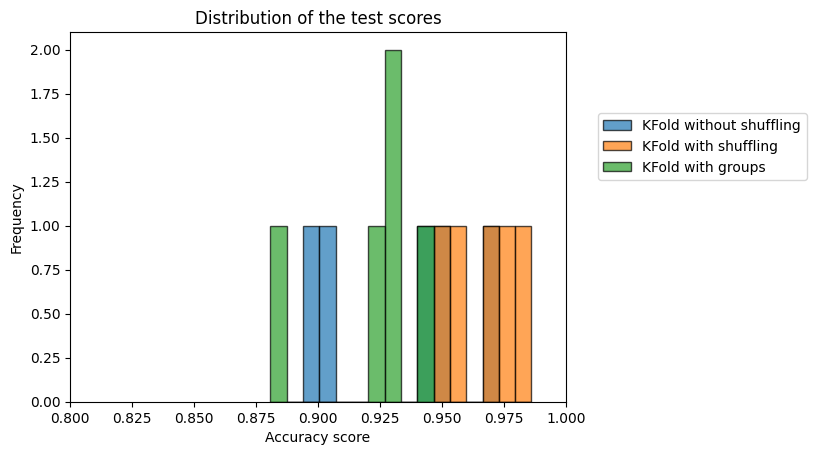

In [14]:
all_scores.plot.hist(bins=16, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

## Key Takeaways and When to Use Grouping

### Essential Concepts
1. **Data Leakage Prevention**: Group-aware CV prevents information leakage between training and test sets
2. **Realistic Performance Estimates**: Lower but honest scores are better than optimistic but misleading ones
3. **Structure Matters**: Always investigate the natural structure of your data before choosing a CV strategy

### When Should You Consider Grouping?

**Definitely use grouping when you have:**
- **Time series data**: Multiple measurements from the same time period or entity
- **Medical data**: Multiple samples/visits from the same patient
- **Image data**: Multiple images from the same person, object, or scene
- **Text data**: Multiple documents from the same author or source
- **Sensor data**: Multiple readings from the same device or location
- **Financial data**: Multiple transactions from the same customer or account

**Questions to ask yourself:**
- Are there natural clusters or relationships in my data?
- Could samples from the same source appear in both training and test sets?
- Does my model need to generalize to completely new entities/sources?
- Would domain experts consider certain samples as "related"?

### Other Group-Aware Strategies
Besides `GroupKFold`, scikit-learn provides:
- `LeaveOneGroupOut`: Use each group as a test set once
- `LeavePGroupsOut`: Use P groups as test set in each fold  
- `GroupShuffleSplit`: Random sampling while respecting groups
- `StratifiedGroupKFold`: Stratified sampling with group constraints

### Real-World Impact
Proper cross-validation with grouping:
- ✅ Provides reliable performance estimates
- ✅ Prevents deployment of overoptimistic models  
- ✅ Builds trust in machine learning systems
- ✅ Reduces the risk of model failures in production

Remember: **It's better to have a realistic estimate of 85% accuracy than a misleading estimate of 95% accuracy!**

The interested reader can learn about other group-aware cross-validation techniques in the [scikit-learn user guide](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data).

## Practice Exercise for Students

**Try This Yourself:**
1. Think of a dataset from your field of study or interest
2. Identify potential grouping structures in that data
3. Consider how ignoring these groups could lead to data leakage
4. Discuss with your peers what the real-world consequences might be

**Reflection Questions:**
- How would you explain the importance of grouping to a project stakeholder?
- What questions would you ask a domain expert to identify potential groups?
- How might the consequences of overoptimistic estimates differ across industries (healthcare, finance, autonomous vehicles, etc.)?